In [1]:
# !pip install experta

In [2]:
import pandas as pd
import pickle as pkl
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import re
from sklearn.tree import export_text

In [3]:
dataset = "Loan-Approval-Prediction-Dataset/loan_approval_dataset.csv"
df = pd.read_csv('datasets/'+dataset)
print(len(df))

4269


In [4]:
df.columns = df.columns.str.strip()
# drop the 'Loan_ID' column as it is not useful for prediction
df.drop(columns=['loan_id'], inplace=True)
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [6]:
df.isnull().sum().sum()

0

In [7]:
print(f"loan_status: {df['loan_status'].value_counts()}")
# Encode categorical data
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]
class_names = ['Approved', 'Rejected']
print(f"loan_status: {df['loan_status'].value_counts()}")

# Define label mapping
label_map = {0: "Approved", 1: "Rejected"}

loan_status: loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


loan_status: loan_status
0    2656
1    1613
Name: count, dtype: int64


In [8]:
# Normalize the data
feature_cols = df.columns[df.columns != "loan_status"]
mx = MinMaxScaler()
df[feature_cols] = mx.fit_transform(df[feature_cols])


In [9]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,              # Try values: None, 3, 5, 10, etc.
    min_samples_split=10,     # Prevent overfitting
    min_samples_leaf=5,       # Minimum samples in a leaf
    min_impurity_decrease=0.001,
    # max_features="sqrt",
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


depth = clf.get_depth()
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Tree Depth: {depth} | Number of Leaves: {clf.get_n_leaves()}")

Test Accuracy: 0.9684
Tree Depth: 4 | Number of Leaves: 9


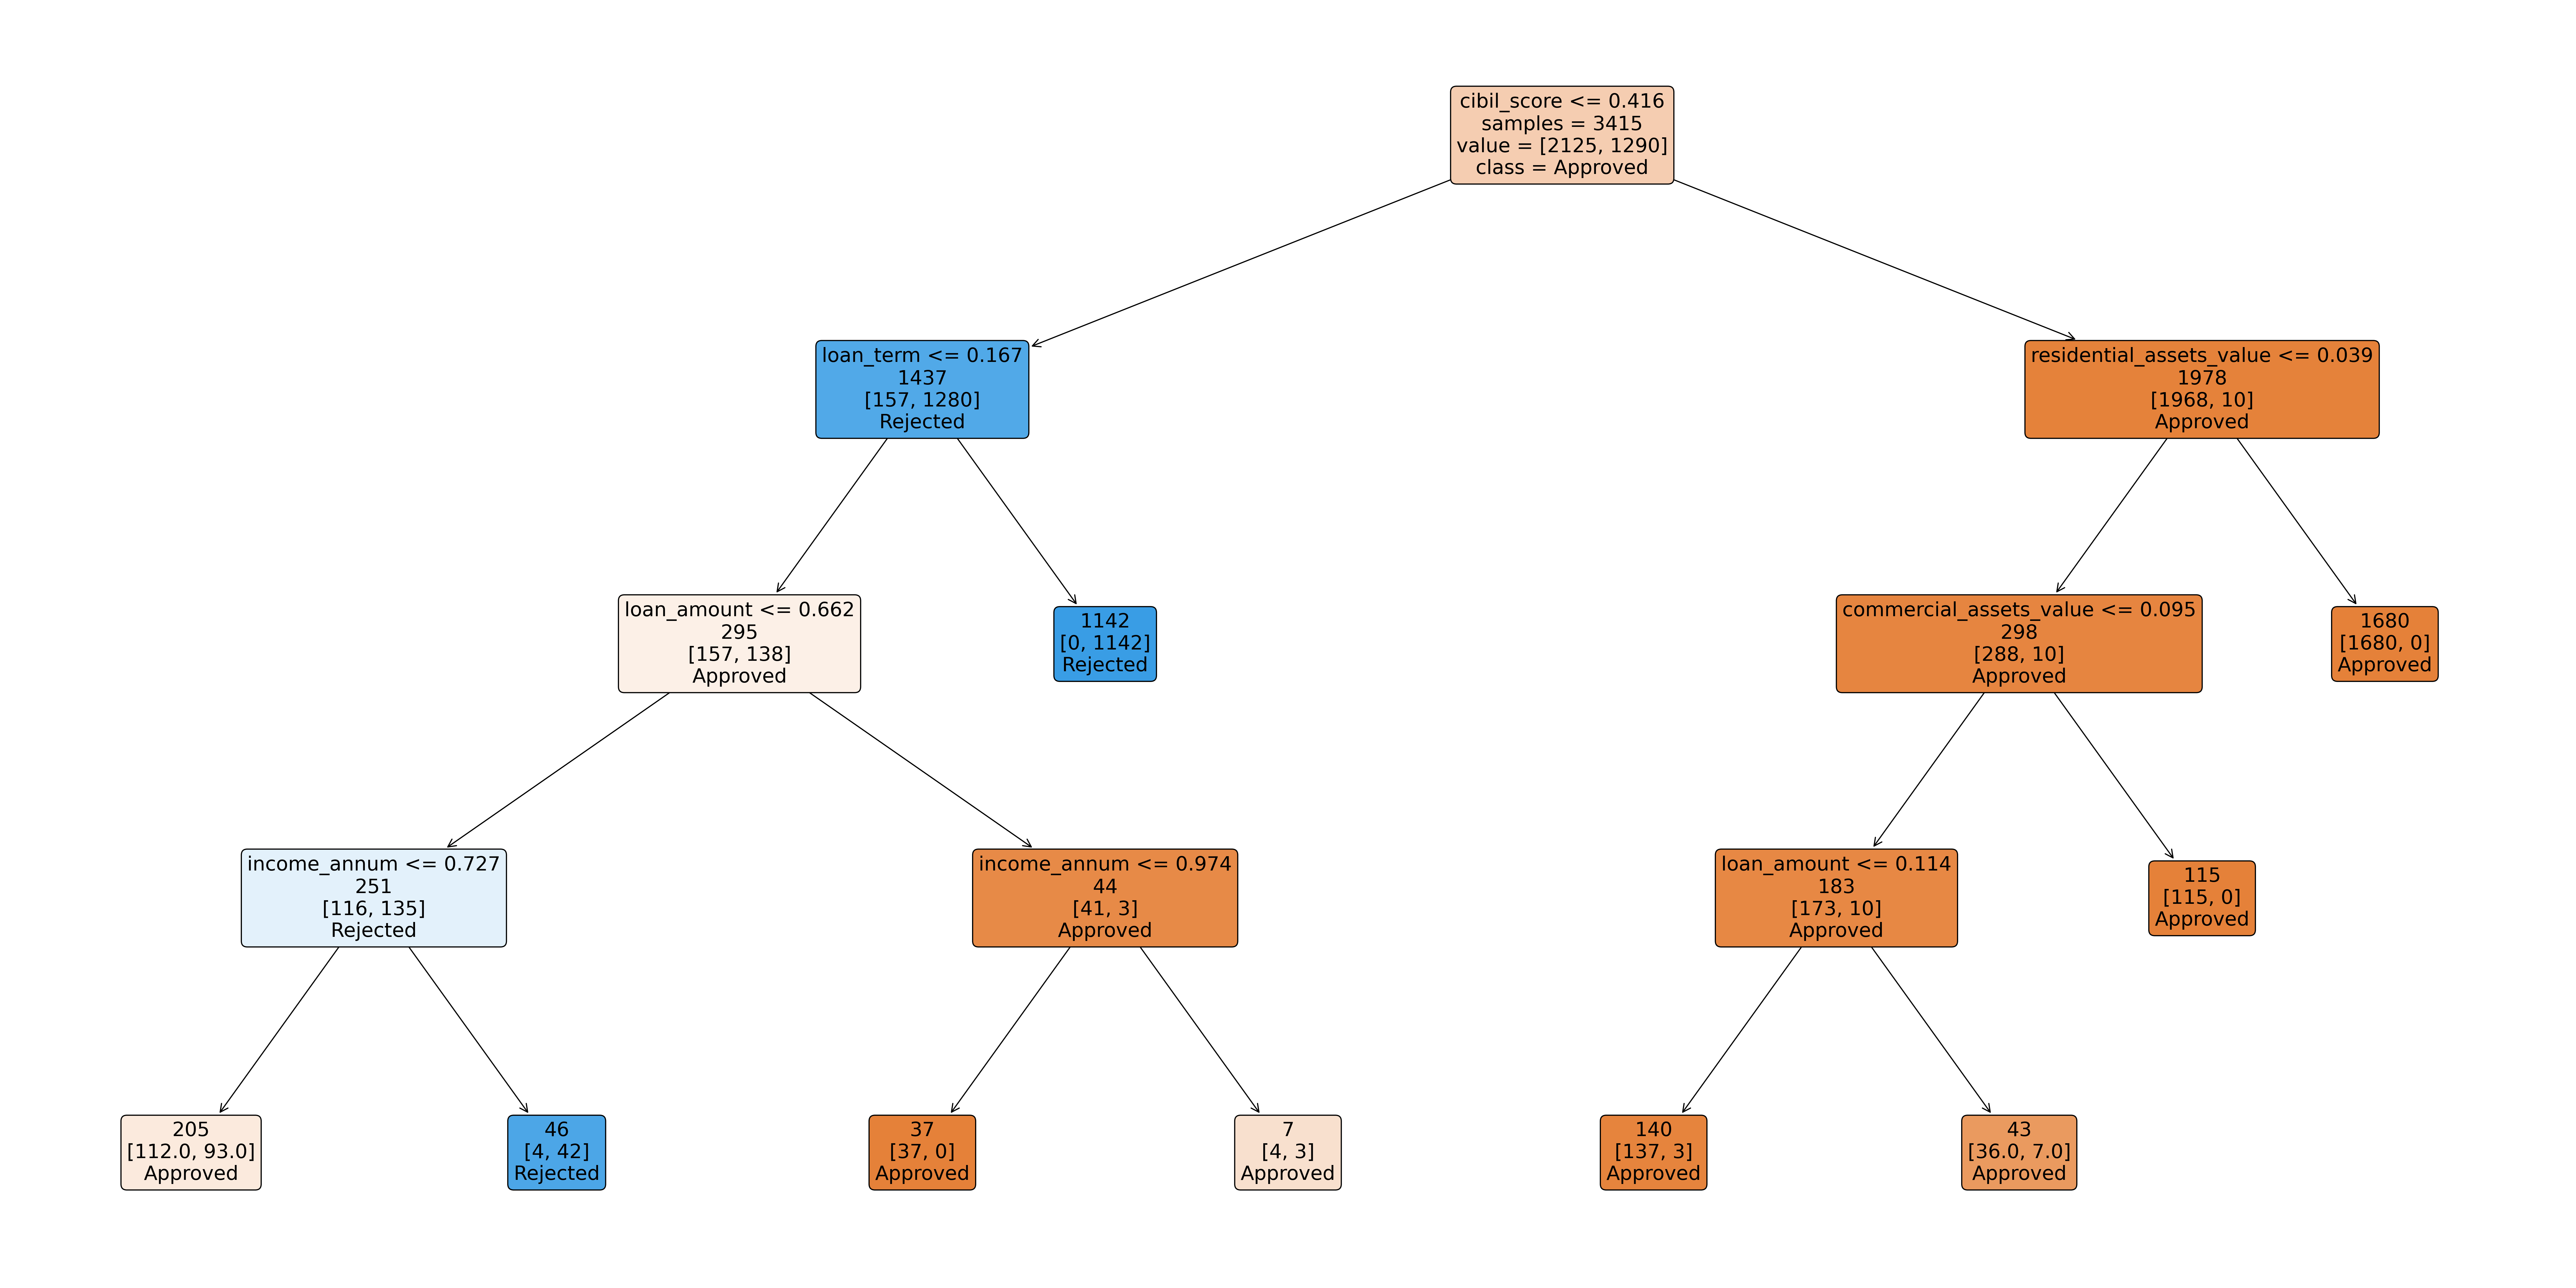

In [10]:
plt.figure(figsize=(40, 20), dpi=300)
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=class_names,
    filled=True,
    rounded=True,
    impurity=False,
    label="root"
)
plt.savefig("Trees/decision_tree_rule_loan.png", bbox_inches="tight")
# plt.close()


In [11]:
tree_rules = export_text(clf, feature_names=list(X.columns), max_depth=depth+5, decimals=5)
# print(rules)
# Write rules to a file
with open("Rules/loan_rules.txt", "w") as f:
    f.write(tree_rules)

In [12]:
# Parse and convert
rules = []
rule_count = 0
stack = []

for line in tree_rules.split("\n"):
    indent_level = line.count("|   ")
    line = line.strip()

    # Remove tree symbols
    line = re.sub(r"\|--- ", "", line)
    line = line.replace("|   ", "")

    if line.startswith("class:"):
        class_val = int(float(line.split(":")[1].strip()))
        class_label = label_map[class_val]
        # Build final rule from stack
        conditions = stack[:indent_level]
        condition_str = ", ".join(conditions)
        rule_code = f"""    @Rule(Fact({condition_str}))
    def rule_{rule_count}(self):
        # print(f"Rule {rule_count}: Loan Status: {class_label}")
        self.prediction = {0 if class_label == "Approved" else 1}\n"""
        rules.append(rule_code)
        rule_count += 1
    elif "<=" in line or ">" in line:
        op = "<=" if " <= " in line else ">"
        feature, op_val = line.split(op)
        val = float(op_val.strip())
        stack = stack[:indent_level] + [f"{feature.strip()}=P(lambda x: x {op} {val})"]

# Output rules
print("""from experta import *\n\nclass LoanExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None\n""")
for r in rules:
    print(r)


from experta import *

class LoanExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x <= 0.66199), income_annum=P(lambda x: x <= 0.7268)))
    def rule_0(self):
        # print(f"Rule 0: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x <= 0.66199), income_annum=P(lambda x: x > 0.7268)))
    def rule_1(self):
        # print(f"Rule 1: Loan Status: Rejected")
        self.prediction = 1

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x > 0.66199), income_annum=P(lambda x: x <= 0.97423)))
    def rule_2(self):
        # print(f"Rule 2: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.4

In [13]:
from experta import *

class LoanExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x <= 0.66199), income_annum=P(lambda x: x <= 0.7268)))
    def rule_0(self):
        # print(f"Rule 0: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x <= 0.66199), income_annum=P(lambda x: x > 0.7268)))
    def rule_1(self):
        # print(f"Rule 1: Loan Status: Rejected")
        self.prediction = 1

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x > 0.66199), income_annum=P(lambda x: x <= 0.97423)))
    def rule_2(self):
        # print(f"Rule 2: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x <= 0.16667), loan_amount=P(lambda x: x > 0.66199), income_annum=P(lambda x: x > 0.97423)))
    def rule_3(self):
        # print(f"Rule 3: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x <= 0.41583), loan_term=P(lambda x: x > 0.16667)))
    def rule_4(self):
        # print(f"Rule 4: Loan Status: Rejected")
        self.prediction = 1

    @Rule(Fact(cibil_score=P(lambda x: x > 0.41583), residential_assets_value=P(lambda x: x <= 0.03938), commercial_assets_value=P(lambda x: x <= 0.09536), loan_amount=P(lambda x: x <= 0.11352)))
    def rule_5(self):
        # print(f"Rule 5: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x > 0.41583), residential_assets_value=P(lambda x: x <= 0.03938), commercial_assets_value=P(lambda x: x <= 0.09536), loan_amount=P(lambda x: x > 0.11352)))
    def rule_6(self):
        # print(f"Rule 6: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x > 0.41583), residential_assets_value=P(lambda x: x <= 0.03938), commercial_assets_value=P(lambda x: x > 0.09536)))
    def rule_7(self):
        # print(f"Rule 7: Loan Status: Approved")
        self.prediction = 0

    @Rule(Fact(cibil_score=P(lambda x: x > 0.41583), residential_assets_value=P(lambda x: x > 0.03938)))
    def rule_8(self):
        # print(f"Rule 8: Loan Status: Approved")
        self.prediction = 0

In [14]:
# Testing on one example

user_input = {
    "no_of_dependents": 4,
    "education": 0,
    "self_employed": 0,
    "income_annum": 7000000,
    "loan_amount": 10,
    "loan_term": 5,
    "cibil_score": 12,
    "residential_assets_value": 200000,
    "commercial_assets_value": 1500000,
    "luxury_assets_value": 22700000,
    "bank_asset_value": 8000000
}
# Convert to DataFrame to transform
input_df = pd.DataFrame([user_input])
normalized_input = mx.transform(input_df)[0]  # 1D array
normalized_fact = dict(zip(df.columns, normalized_input))


# normalized_fact = {
# "no_of_dependents":            0.600000,
# "education":                   1.000000,
# "self_employed":               1.000000,
# "income_annum":                0.237113,
# "loan_amount":                 0.216837,
# "loan_term":                   0.555556,
# "cibil_score":                 0.396667,
# "residential_assets_value":    0.171233,
# "commercial_assets_value":     0.092784,
# "luxury_assets_value":         0.226221,
# "bank_asset_value":            0.224490,
# }

engine = LoanExpert()
engine.reset()
engine.declare(Fact(**normalized_fact))
engine.run()
print(engine.prediction)


0


In [15]:
y_pred_rule = []

for i, row in X_test.iterrows():
    # Run inference using your rule engine
    engine = LoanExpert()
    engine.reset()
    engine.declare(Fact(**row))
    engine.run()
    if engine.prediction is None:
        print("No rule matched for:", row)
    # Append predicted label (assume it's stored in engine.prediction)
    y_pred_rule.append(engine.prediction)

y_pred_tree = clf.predict(X_test)
# Compute accuracy
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred_rule) * 100}%")

Accuracy on test set: 96.8384074941452%
